In [1]:
%matplotlib notebook
'''
Initial code for the download and preparation of HMI data input into amrvac

It works!!!
'''

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from __future__ import division, print_function
import os.path
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.time import Time
import drms
import numpy as np
import time
import calendar

from datetime import timedelta      #for creating time range
from datetime import datetime       #for handling dates

class prepare():
    def __init__(self, sharpnum=None, email=None, working_directory=None):
        '''
        Sets the initial variables necessary to use this module
        
        Email is necessary for request to jsoc servers, this email has to have been pre-approved at: 
        
        First time instructions:
                 - Navigate to: http://jsoc.stanford.edu/ajax/lookdata.html
                 - Input "CGEM" into the "[       ]? Seriesname filter" field and click "Fetch seriesname list" button
                 - Under "2. Pick series to use" select "cgem.pdfi_input"
                 - On the new page, tick the "?   Check box to show the QueryBuilder."
                 - Type "11158" into the "CGEMNUM" field and click "GetRecordCount"
                 - When "Record Count" is returned, select "Fetch Keyword Values for RecordSet"
                 - You should now be on the "Values Display" tab, navigate to the next tab 
                 titled "Export Data" and click the "export" button
                 - This should open a new tab/window. In the Notify field, input your desired email address and 
                 click "Check Parameters". A verification email will be sent to the indicated address - follow 
                 the instructions there to register your email.
                 - In the event that your webserver is 'too slow' then you can directly email: arta@sun.stanford.edu 
                 and request for your email to be manually added. A warning if you are trying this many years after 
                 2021 that this address may have changed.
                 - You should now be able to submit requests to, and download from, the JSOC server as you wish.
        ''' 
        
        default=''
        if email == None:
            email='jack.jenkins@kuleuven.be'
            default=' default'
        print('Using'+default+' email: '+email)
        self.email=email
        
        if working_directory == None:
            working_directory='./'
        self.working_directory=working_directory
        
        if sharpnum == None:
            raise SystemExit("Please specify SHARP # in process() call")
        self.sharpnum=sharpnum
        
        self.download_location=None
        
    

    def jsoc_sharp_date_query(self, sharpnum=None):
        '''
        A subroutine used to check the date associated with a supplied sharp#
        
        Input is expected as a string
        
        Returns the date associated with when this sharp AR was closest to central meridian
        
        '''
        
        if sharpnum: self.sharpnum=sharpnum
        c = drms.Client(email=self.email) ##Use your own email address.
        kwlist = ['T_REC', 'LON_FWT', 'OBS_VR', 'CROTA2',
          'CRPIX1', 'CRPIX2', 'CDELT1', 'CDELT2', 'CRVAL1', 'CRVAL2']
        k = c.query('hmi.sharp_cea_720s['+self.sharpnum+']', key=kwlist, rec_index=True)

        rec_cm = k.LON_FWT.abs().idxmin()
        k_cm = k.loc[rec_cm]
        t_cm = drms.to_datetime(k.T_REC[rec_cm])
        print(rec_cm, '@', k.LON_FWT[rec_cm], 'deg')
        print('Timestamp:', t_cm)
        return t_cm
        
    def jsoc_cgem_build_query(self, cgemnum=None, t_start=None, t_end=None, segments='*'):
        '''
        Subroutine used to build the JSOC query for the CGEM data product
        
        Builds a query following the drms method
        
        Requires a CGEMNUM following their definition on JSOC - can use .jsoc_cgem_num_query to find a CGEMNUM
        that corresponds to a specific sharp number
        
        t_start and t_end used to specify a window over which to search for or download associated files
        
        '''
        
        if cgemnum: self.cgemnum=cgemnum
        #search for and download data from JSOC
        client = drms.Client()                                   #establish client
        #search query
        ds = ('cgem.pdfi_input['+self.cgemnum+']'
              '['+t_start.strftime('%Y.%m.%d_%H:%M')+'-'
              +t_end.strftime('%Y.%m.%d_%H:%M')+']{'+segments+'}')
        self.client=client
        self.ds=ds

    def jsoc_cgem_num_query(self, sharpnum=None, t_start=None, t_end=None, debug=False):
        '''
        A subroutine to find the CGEM number associated with the sharpnumber provided by the user.
        
        t_start and t_end to specify window over which to search for the associated sharp number
        Cannot omit this, will make search query too large - will either fail on JSOC end or take 
        way too long to complete.
        
        '''
        
        
        if sharpnum: self.sharpnum=sharpnum
        if debug==True: print('self.sharpnum now: ', str(self.sharpnum))
        c = drms.Client(email=self.email)
        kwlist = ['T_REC', 'CGEMNUM', 'HARPNUM', 'CROTA2',
          'CRPIX1', 'CRPIX2', 'CDELT1', 'CDELT2', 'CRVAL1', 'CRVAL2']
        k = c.query('cgem.pdfi_input[]['+t_start.strftime('%Y.%m.%d_%H:%M')+'-'
                    +t_end.strftime('%Y.%m.%d_%H:%M')+']', key=kwlist, rec_index=True)
        
        cgemnum=k.CGEMNUM[k.HARPNUM==int(self.sharpnum)]
        if cgemnum.size>0:
            print('CGEMNUM for HARP#'+str(self.sharpnum)+': '+str(k.CGEMNUM[k.HARPNUM==int(self.sharpnum)][0]))
        else:
            raise SystemExit("No CGEM number found for harp#"+self.sharpnum)
        self.cgemnum=str(k.CGEMNUM[k.HARPNUM==int(self.sharpnum)][0])
        if debug==True: print('self.cgemnum now:', str(k.CGEMNUM[k.HARPNUM==int(self.sharpnum)][0]))
        
    def jsoc_request(self, email=None, method='url', protocol='fits'):

        #prepare data from JSOC
        r = self.client.export(self.ds, email=self.email, method=method, protocol=protocol)
        print(r.data.filename)
        self.request=r

    def jsoc_download(self, series=None, cgem_stage='input', wait=False, download_location=None, verbose=True):

        if download_location == None:
            download_location = self.working_directory + 'downloads/'+str(self.sharpnum)+'/'
        self.download_location=download_location
        if series: self.download_location = self.download_location + series + '/'
        if series=='cgem': 
            self.download_location = self.download_location + cgem_stage + '/'
        if wait:
            self.request.wait()                #force time between preparation and request
        self.request.request_url                                #request data from JSOC
        self.request.download(self.download_location, verbose=verbose)          #download data
        print('Requested files successfully downloaded')

        '''
        When downloading files from jsoc it double-downloads those files already present within the folder and appends a .x
        , where x is a number, after the filename. The following searches for additional files indexed up to 10
        and sequentially reduced this number to 0 before removing this suffix from the file ending in .0
        This ensures that the latest file downloaded i.e., the file with the largest numerical suffix is the
        one maintained for later plotting or passing to the sptf function
        '''
        for i in range(10,-1,-1):
            s='.fits.{0:01d}'.format(i)
            files = [self.download_location+f for f in listdir(self.download_location) if isfile(join(self.download_location, f))
                and s in f]
            for filename in files:
                if i==0:
                    os.rename(filename,filename[:-2])
                else:
                    os.rename(filename,filename[:-2]+'.{0:01d}'.format(i-1))

    
    def read_fits_data(self, series=None, segment=None, download_location=None):
        if (self.download_location and download_location) == None:
            download_location = self.working_directory + 'downloads/'+str(self.sharpnum)+'/'
            self.download_location=download_location
        if series: self.download_location = self.download_location + series + '/'
        if series=='cgem': self.download_location = self.download_location + 'input/'
        if isinstance(segment, str):
            segment=[segment]
        
        s=segment[0]
#         s=segment
        files = [self.download_location+f for f in listdir(self.download_location) if isfile(join(self.download_location, f))
                and s in f]
        
        files=sorted(files)
        
        hmilist_header_array=[]
        hmilist_data_array=[]
        hmilist=[]
        
        for s in segment:
            for i in range(len(files)):
                hmilist.append(fits.open(files[i]))
                hmilist[i].verify('silentfix+warn')
                hmilist_header_array.append(hmilist[i][-1].header)
                hmilist_data_array.append(hmilist[i][-1].data)
        
        return hmilist_data_array, hmilist_header_array
    


In [6]:
sharpnum = '401'                     #HARP region http://jsoc.stanford.edu/doc/data/hmi/harp/harp_definitive/
sharp_segments = 'br,bp,bt'                #data segments to download, comma separated
cgem_segments='*'
cadence = '12m'                      #cadence of data to download e.g. '12m'
t_delta = timedelta(days=0.01)         #+/- time range to search for data


email = 'jack.jenkins@kuleuven.be'   #email address verified with jsoc @ http://jsoc.stanford.edu/ajax/exportdata.html


process=prepare(sharpnum=sharpnum, email='jack.jenkins@kuleuven.be')

####These two go together####
event=process.jsoc_sharp_date_query(sharpnum)
event=str(event.year)+'-'+calendar.month_abbr[event.month]+'-'+f"{event.day:02d}" 
#############################

date = datetime.strptime(event, '%Y-%b-%d') #event string to datetime object
t_start = date - t_delta                    #start time for data interval
t_end = date + t_delta                      #end time for data interval


process.jsoc_cgem_num_query(sharpnum=sharpnum,t_start=t_start, t_end=t_end, debug=False)
process.jsoc_cgem_build_query(t_start=t_start, t_end=t_end, segments=cgem_segments)

process.jsoc_request(method='url', protocol='fits')
process.jsoc_download(series='cgem', cgem_stage='input', verbose=True)

Using email: jack.jenkins@kuleuven.be
hmi.sharp_cea_720s[401][2011.03.09_04:36:00_TAI] @ -0.001073 deg
Timestamp: 2011-03-09 04:36:00
CGEMNUM for HARP#401: 11166
0     cgem.pdfi_input.11166.20110308_234800_TAI.Blon...
1     cgem.pdfi_input.11166.20110308_234800_TAI.Blat...
2     cgem.pdfi_input.11166.20110308_234800_TAI.Brll...
3     cgem.pdfi_input.11166.20110308_234800_TAI.Vlon...
4     cgem.pdfi_input.11166.20110308_234800_TAI.Vlat...
5     cgem.pdfi_input.11166.20110308_234800_TAI.Vlos...
6     cgem.pdfi_input.11166.20110308_234800_TAI.Llon...
7     cgem.pdfi_input.11166.20110308_234800_TAI.Llat...
8     cgem.pdfi_input.11166.20110308_234800_TAI.Lrll...
9     cgem.pdfi_input.11166.20110309_000000_TAI.Blon...
10    cgem.pdfi_input.11166.20110309_000000_TAI.Blat...
11    cgem.pdfi_input.11166.20110309_000000_TAI.Brll...
12    cgem.pdfi_input.11166.20110309_000000_TAI.Vlon...
13    cgem.pdfi_input.11166.20110309_000000_TAI.Vlat...
14    cgem.pdfi_input.11166.20110309_000000_TAI.Vlos..

Using default email: jack.jenkins@kuleuven.be


<IPython.core.display.Javascript object>


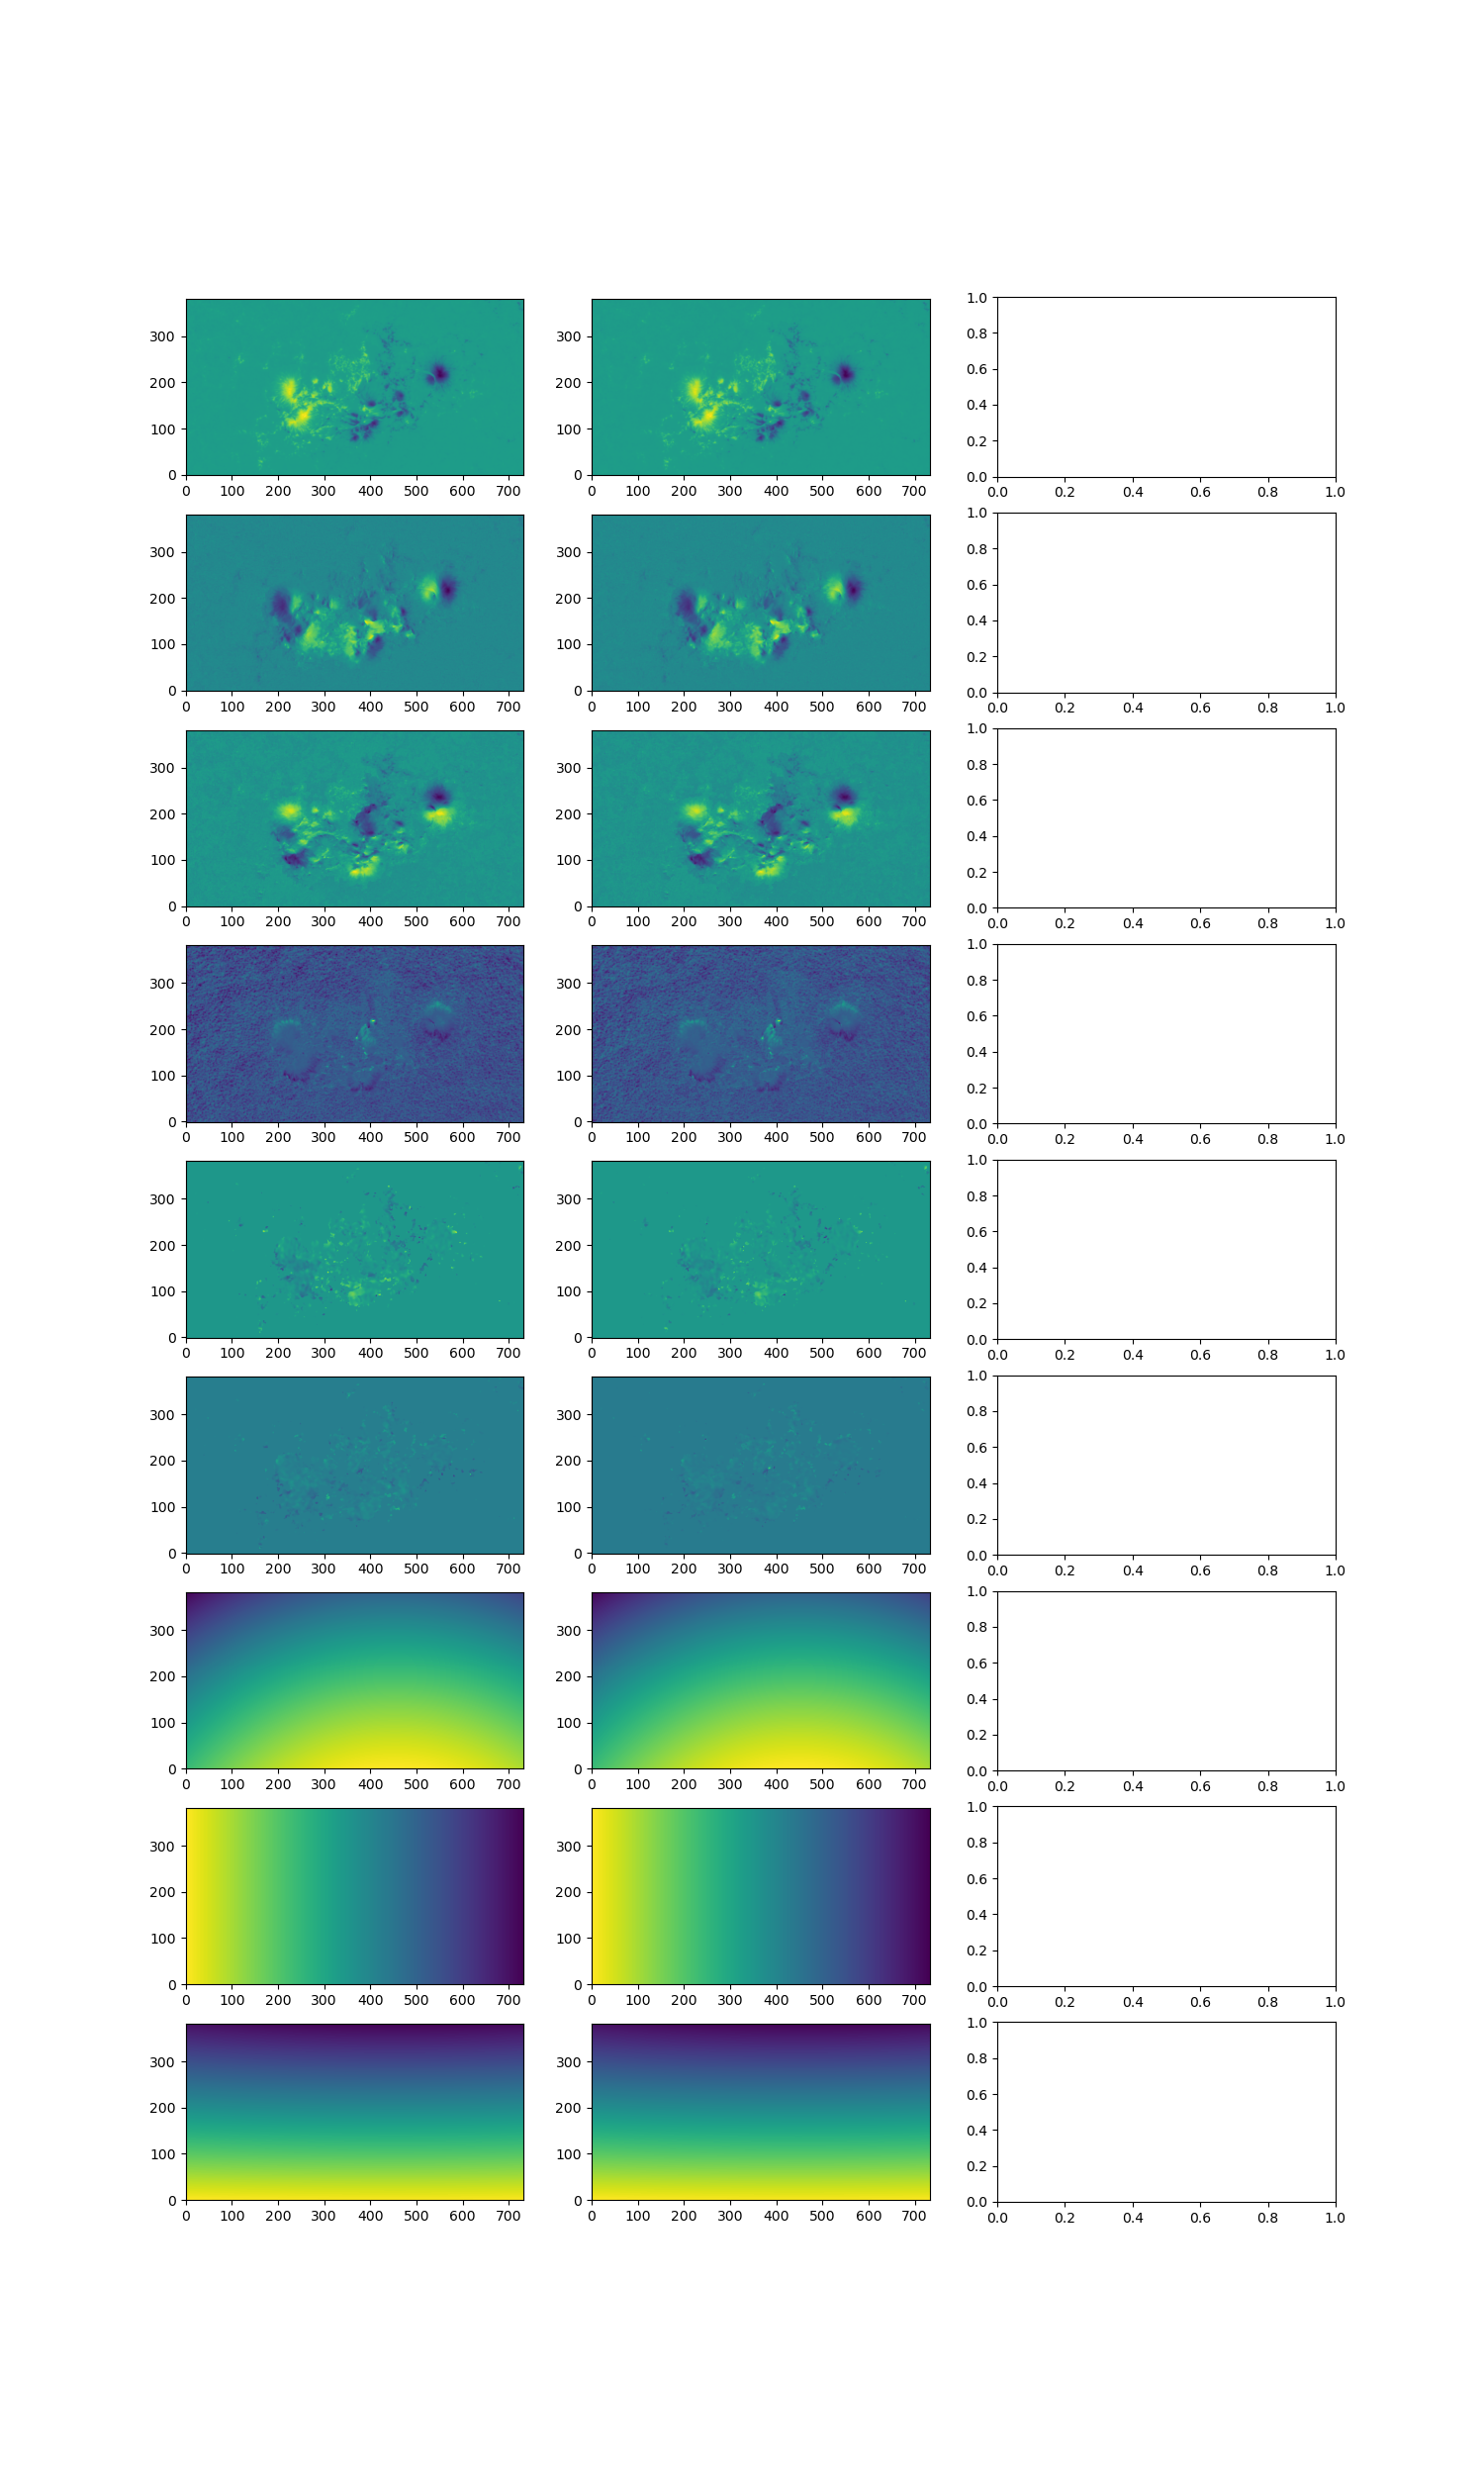

In [7]:
### Included here to avoid the prepping steps in the previous ipython cell
sharpnum = '401'
process=prepare(sharpnum=sharpnum)
###

Br, header = process.read_fits_data(series='cgem', segment='Brllcoe')
Blon, header = process.read_fits_data(series='cgem', segment='Bloncoe')
Blat, header = process.read_fits_data(series='cgem', segment='Blatcoe')
Vr, header = process.read_fits_data(series='cgem', segment='Vlosllcoe')
Vlon, header = process.read_fits_data(series='cgem', segment='Vloncoe')
Vlat, header = process.read_fits_data(series='cgem', segment='Vlatcoe')
Lr, header = process.read_fits_data(series='cgem', segment='Lrllcoe')
Llon, header = process.read_fits_data(series='cgem', segment='Lloncoe')
Llat, header = process.read_fits_data(series='cgem', segment='Llatcoe')

plot=True
if plot:
    fig, ((ax1,ax2,axd1),(ax3,ax4,axd2),(ax5,ax6,axd3)
      ,(ax7,ax8,axd4),(ax9,ax10,axd5),(ax11,ax12,axd6)
      ,(ax13,ax14,axd7),(ax15,ax16,axd8),(ax17,ax18,axd9)) = plt.subplots(9,3,figsize=(15,25))
    ax1.imshow(Br[0],origin='lower')
    ax2.imshow(Br[1],origin='lower')
    ax3.imshow(Blon[0],origin='lower')
    ax4.imshow(Blon[1],origin='lower')
    ax5.imshow(Blat[0],origin='lower')
    ax6.imshow(Blat[1],origin='lower')
    ax7.imshow(Vr[0],origin='lower')
    ax8.imshow(Vr[1],origin='lower')
    ax9.imshow(Vlon[0],origin='lower')
    ax10.imshow(Vlon[1],origin='lower')
    ax11.imshow(Vlat[0],origin='lower')
    ax12.imshow(Vlat[1],origin='lower')
    ax13.imshow(Lr[0],origin='lower')
    ax14.imshow(Lr[1],origin='lower')
    ax15.imshow(Llon[0],origin='lower')
    ax16.imshow(Llon[1],origin='lower')
    ax17.imshow(Llat[0],origin='lower')
    ax18.imshow(Llat[1],origin='lower')w

#     axd1.imshow(Br[1]-Br[0])
#     axd2.imshow(Blon[1]-Blon[0])
#     axd3.imshow(Blat[1]-Blat[0])
#     axd4.imshow(Vr[1]-Vr[0])
#     axd5.imshow(Vlon[1]-Vlon[0])
#     axd6.imshow(Vlat[1]-Vlat[0])
#     axd7.imshow(Lr[1]-Lr[0])
#     axd8.imshow(Llon[1]-Llon[0])
#     axd9.imshow(Llat[1]-Llat[0])


In [10]:
from save_pdfi_to_sdf import save_pdfi_to_sdf as sptf

t0_to_fortran=np.zeros(len(Br))
t1_to_fortran=np.zeros(len(Br))

number_of_files=len(Br)

for i in range(len(Br)-1):
    #Need to update this to accept variable dt, currently assumes all images are spaced by identical dt
    t0=int(drms.to_datetime(header[i]['T_REC']).strftime('%s'))
    t1=int(drms.to_datetime(header[i+1]['T_REC']).strftime('%s'))
    dt=(t1-t0)/86400.
    t0_to_fortran[i]=i*dt
    t1_to_fortran[i]=t0_to_fortran[i]+dt

for i in range(len(Br)-1):
    #Individual arrays tranposed as np.tranpose doesn't take an order keyword
    final_array_to_fortran=np.zeros((Br[0].shape[1],Br[0].shape[0],18), order='F')
    final_array_to_fortran[:,:,0]=np.transpose(Blon[i])
    final_array_to_fortran[:,:,1]=np.transpose(Blat[i])
    final_array_to_fortran[:,:,2]=np.transpose(Br[i])
    final_array_to_fortran[:,:,3]=np.transpose(Blon[i+1])
    final_array_to_fortran[:,:,4]=np.transpose(Blat[i+1])
    final_array_to_fortran[:,:,5]=np.transpose(Br[i+1])
    final_array_to_fortran[:,:,6]=np.transpose(Vlon[i])
    final_array_to_fortran[:,:,7]=np.transpose(Vlat[i])
    final_array_to_fortran[:,:,8]=np.transpose(Vr[i])
    final_array_to_fortran[:,:,9]=np.transpose(Vlon[i+1])
    final_array_to_fortran[:,:,10]=np.transpose(Vlat[i+1])
    final_array_to_fortran[:,:,11]=np.transpose(Vr[i+1])
    final_array_to_fortran[:,:,12]=np.transpose(Llon[i])
    final_array_to_fortran[:,:,13]=np.transpose(Llat[i])
    final_array_to_fortran[:,:,14]=np.transpose(Lr[i])
    final_array_to_fortran[:,:,15]=np.transpose(Llon[i+1])
    final_array_to_fortran[:,:,16]=np.transpose(Llat[i+1])
    final_array_to_fortran[:,:,17]=np.transpose(Lr[i+1])

    a=header[i]['MINCOLAT']
    b=header[i]['MAXCOLAT']
    c=header[i]['MINLON']
    d=header[i]['MAXLON']
    m=int(header[i]['NAXIS2'])
    n=int(header[i]['NAXIS1'])

    output=sptf(final_array_to_fortran,int(sharpnum),a,b,c,d,i,t0_to_fortran,t1_to_fortran,m,n,number_of_files)


ImportError: dlopen(/Users/jackjenkins/Work/new_volume/Projects/amrvac/data_driven/data_driven/save_pdfi_to_sdf.cpython-38-darwin.so, 2): no suitable image found.  Did find:
	/Users/jackjenkins/Work/new_volume/Projects/amrvac/data_driven/data_driven/save_pdfi_to_sdf.cpython-38-darwin.so: mach-o, but wrong architecture
	/Users/jackjenkins/Work/new_volume/Projects/amrvac/data_driven/data_driven/save_pdfi_to_sdf.cpython-38-darwin.so: mach-o, but wrong architecture

In [ ]:
asd=output
maxbrtest=abs(abs(final_array_to_fortran[:,:,2].max())-abs(asd[:,:,0].max()))<200.
minbrtest=abs(abs(final_array_to_fortran[:,:,2].min())-abs(asd[:,:,0].min()))<200.
# print(brtest)
print('max: B field before: ',final_array_to_fortran[:,:,2].max(),
      ' bfield after: ', asd[:,:,0].max(),
      '==> Within error' if (maxbrtest==True) else '==> !Outside error!')
print('min: B field before: ',final_array_to_fortran[:,:,2].min(),
      ' bfield after: ', asd[:,:,0].min(),
      '==> Within error' if (minbrtest==True) else '==> !Outside error!')
print('max: E theta field: ', asd[:,:,1].max())
print('min: E theta field: ', asd[:,:,1].min())
print('max: E phi field: ', asd[:,:,2].max())
print('min: E phi field: ', asd[:,:,2].min())


fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,30))
ax1.imshow(asd[:,:,0])
ax2.imshow(asd[:,:,1])
ax3.imshow(asd[:,:,2])

In [5]:
print(sptf.__doc__)

output = save_pdfi_to_sdf(input,sharpnum,as,bs,cs,ds,index_bn,tjul0,tjul1,[msp1,nsp1,index_total])

Wrapper for ``save_pdfi_to_sdf``.

Parameters
----------
input : input rank-3 array('d') with bounds (nsp1,msp1,18)
sharpnum : input int
as : input float
bs : input float
cs : input float
ds : input float
index_bn : input int
tjul0 : input rank-1 array('d') with bounds (index_total)
tjul1 : input rank-1 array('d') with bounds (index_total)

Other Parameters
----------------
msp1 : input int, optional
    Default: shape(input,1)
nsp1 : input int, optional
    Default: shape(input,0)
index_total : input int, optional
    Default: len(tjul0)

Returns
-------
output : rank-3 array('d') with bounds (400,400,3)

